In [1]:
from os import getcwd, listdir
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
DATASET = getcwd() + "/dataset3/custom/"
CLASSES = 3
IMG_WIDTH = 300
IMG_HEIGHT = 200
BATCH_SIZE = 2
NB_TRAIN_SAMPLES = 240
NB_VALIDATION_SAMPLES = 60
EPOCHS = 50

In [3]:
DATASET

'/home/amogh/Documents/Study/PiRockPaperScissors/notebooks/dataset3/custom/'

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    DATASET,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
)

validation_generator = test_datagen.flow_from_directory(
    DATASET,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [5]:
model = models.Sequential()
model.add(
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(CLASSES, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 99, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 97, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 46, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 209024)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

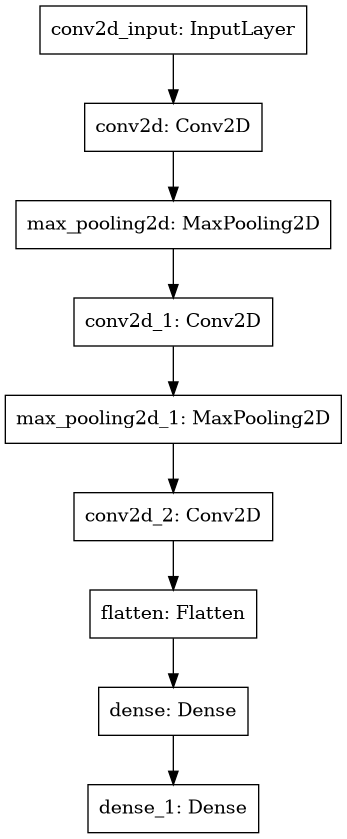

In [6]:
plot_model(model)

In [9]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=5, verbose=1, restore_best_weights=True
)

callbacks = [earlystop]

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

history = model.fit(
    train_generator,
    steps_per_epoch=NB_TRAIN_SAMPLES // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=NB_VALIDATION_SAMPLES // BATCH_SIZE,
)

Epoch 1/50
240/240 [==============================] - 8s 31ms/step - loss: 0.9842 - accuracy: 0.5021 - val_loss: 1.1225 - val_accuracy: 0.3833
Epoch 2/50
240/240 [==============================] - 7s 29ms/step - loss: 0.4979 - accuracy: 0.7417 - val_loss: 1.5896 - val_accuracy: 0.4750
Epoch 3/50
240/240 [==============================] - 7s 29ms/step - loss: 0.3907 - accuracy: 0.8125 - val_loss: 0.9239 - val_accuracy: 0.6250
Epoch 4/50
240/240 [==============================] - 7s 29ms/step - loss: 0.2091 - accuracy: 0.9292 - val_loss: 0.3687 - val_accuracy: 0.9083
Epoch 5/50
240/240 [==============================] - 7s 29ms/step - loss: 0.4798 - accuracy: 0.8479 - val_loss: 0.9864 - val_accuracy: 0.4917
Epoch 6/50
240/240 [==============================] - 7s 29ms/step - loss: 0.1990 - accuracy: 0.9354 - val_loss: 0.4389 - val_accuracy: 0.8583
Epoch 7/50
240/240 [==============================] - 7s 29ms/step - loss: 0.1576 - accuracy: 0.9500 - val_loss: 0.7099 - val_accuracy: 0.6667

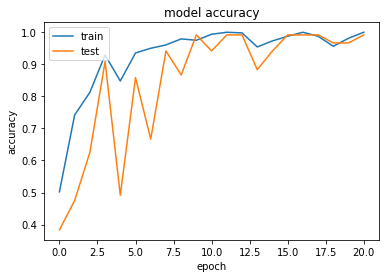

In [10]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

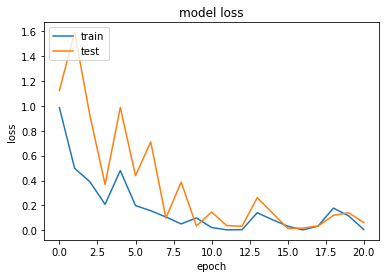

In [11]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [12]:
model.save("rps-cnn-best.h5")

In [13]:
model.save_weights("rps-cnn-weights-best.h5")

In [14]:
loaded_model = load_model(getcwd() + "/rps-cnn-best.h5")

In [15]:
Y_pred = loaded_model.predict_generator(
    validation_generator, NB_VALIDATION_SAMPLES // BATCH_SIZE + 1
)
y_pred = np.argmax(Y_pred, axis=1)

class_labels = {v: k for k, v in validation_generator.class_indices.items()}

print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred))

print("Classification Report")
target_names = list(class_labels.values())
print(
    classification_report(
        validation_generator.classes, y_pred, target_names=target_names
    )
)

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[40  0  0]
 [ 0 40  0]
 [ 1  0 39]]
Classification Report
              precision    recall  f1-score   support

       paper       0.98      1.00      0.99        40
        rock       1.00      1.00      1.00        40
     scissor       1.00      0.97      0.99        40

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



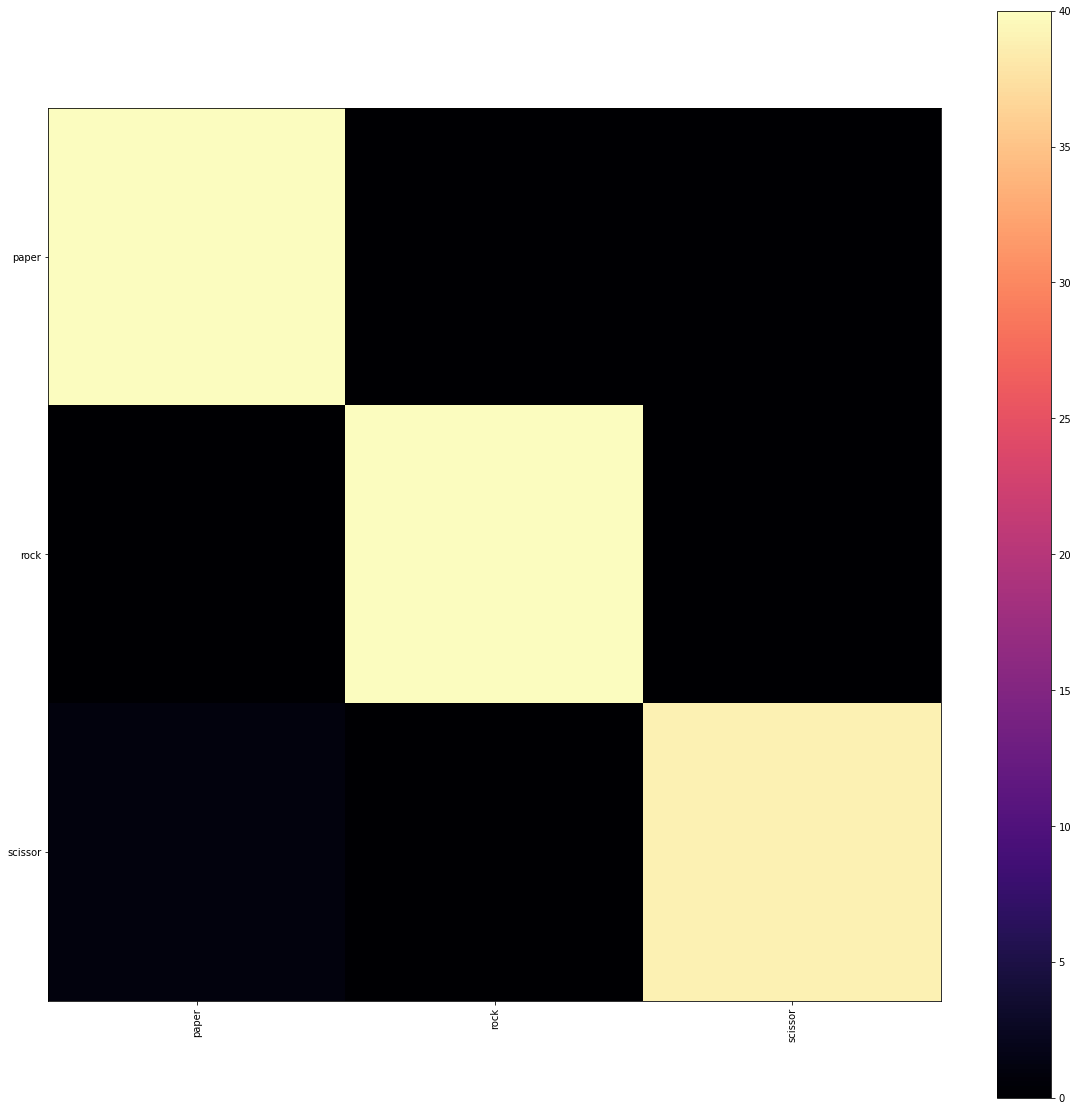

In [16]:
plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)
plt.imshow(cnf_matrix, interpolation='nearest', cmap = "magma")
plt.colorbar()

classes = list(class_labels.values())

tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

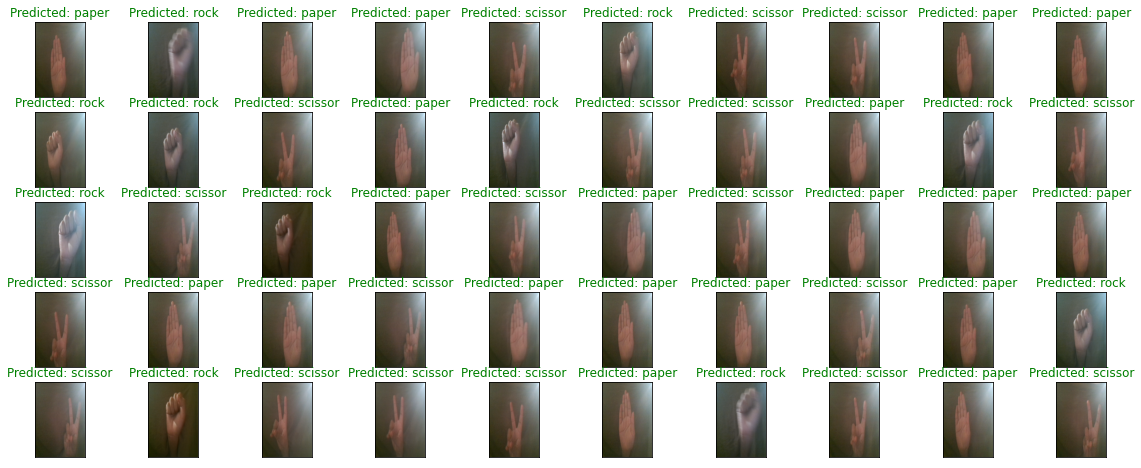

In [18]:
path = DATASET

fig = plt.figure(figsize=(20, 8))


def predictedLabelColor(original, predicted):
    if original == predicted:
        return "green"
    else:
        return "red"


for i in range(50):
    rps_names = listdir(path)
    rps_names_folders = listdir(path)
    random_rps_index = np.random.randint(0, len(rps_names))
    rps_name = rps_names_folders[random_rps_index]

    rps_images_path = path + "/" + rps_name
    rps_images = listdir(rps_images_path)
    random_rps_image_index = np.random.randint(0, len(rps_images))
    rps_image = rps_images[random_rps_image_index]
    rps_image_path = rps_images_path + "/" + rps_image

    result_image_array = image.img_to_array(
        image.load_img(rps_image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    )
    normalized_result = result_image_array * 1.0 / 255
    expanded_result = np.expand_dims(normalized_result, axis=0)
    classes = loaded_model.predict_classes(expanded_result, batch_size=10)
    predicted_label = class_labels[classes[0]]

    ax = fig.add_subplot(5, 10, 1 + i, xticks=[], yticks=[])
    ax.set_title(
        "Predicted: {}".format(predicted_label),
        color=predictedLabelColor(rps_name, predicted_label),
    )
    plt.imshow(normalized_result)

plt.show()